<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Supervised_Training_ImageNet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 14:17:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [4]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [5]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [6]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  4%|▎         | 9/250 [00:00<00:02, 81.34it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 168.89it/s]


(250, 224, 224, 3) (250,)


In [8]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [9]:
# Set up TensorFlow dataset for performance optimization

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Utilities

In [15]:
# Architecture utils
def get_resnet(trainable=True):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = trainable
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=False)
    pooled_features = GlobalAveragePooling2D()(features)

    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [16]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

## Training

In [17]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [18]:
get_resnet(trainable=True).summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/200
20/20 [==============================] - 28s 1s/step - loss: 2.2227 - accuracy: 0.2184 - val_loss: 1.6200 - val_accuracy: 0.2000
Epoch 2/200
20/20 [==============================] - 26s 1s/step - loss: 1.6126 - accuracy: 0.2224 - val_loss: 1.5997 - val_accuracy: 0.3400
Epoch 3/200
20/20 [==============================] - 25s 1s/step - loss: 1.6088 - accuracy: 0.2080 - val_loss: 1.6002 - val_accuracy: 0.1960
Epoch 4/200
20/20 [==============================] - 25s 1s/step - loss: 1.5901 - accuracy: 0.2632 - val_loss: 1.5988 - val_accuracy: 0.2240
Epoch 5/200
20/20 [==============================] - 26s 1s/step - loss: 1.5490 - accuracy: 0.2688 - val_loss: 1.5326 - val_accuracy: 0.2760
Epoch 6/200
20/20 [==============================] - 25s 1s/step - loss: 1.4604 - accuracy: 0.3400 - val_loss: 1.3808 - val_accuracy: 0.3440
Epoch 7/200
20/20 [==============================] - 26s 1s/step - loss: 1.4578 - accuracy: 0.3432 - val_loss: 1.3162 - val_accuracy: 0.4160
Epoch 8/200
2

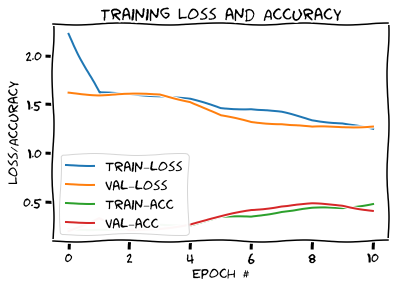

In [20]:
# Train the supervised model with full data
model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=200,
                    callbacks=[es])
plot_training(history)